## Машинное обучение, ВМК МГУ

## Практическое задание 2

### Общая информация
Дата выдачи: 7 октября 2020

Максимальная оценка: 10 баллов + 1 бонусный балл

Мягкий дедлайн: 23:59MSK 20 октября

Жесткий дедлайн: 23:59MSK 27 октября.

### О задании

В этом задании вы:
- Познакомитесь с методом решения задачи регрессии на основе метода ближайших соседей.
- Реализуете алгоритм kNN для задачи регрессии.
- Изучите методы работы с категориальными и текстовыми переменными.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-02-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-02-ivanov.ipynb).

Далее отправьте этот файл на anytask в соответсвующий раздел.

In [ ]:
import numpy as np
import pandas as pd

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования New York City Airbnb Open Data: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data#AB_NYC_2019.csv

В данной задаче предлагается предсказать цену на съем квартиры в зависимости от её параметров.

In [ ]:
data = pd.read_csv(path + 'AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
data.shape

(48895, 16)

In [ ]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

id 48895
name 47906
host_id 37457
host_name 11453
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1765
reviews_per_month 938
calculated_host_listings_count 47
availability_365 366


In [ ]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Как видите, в данных есть пропуски. Не забудьте обработать их

In [ ]:
columns = data.columns
data.replace(np.nan, {columns[1]:'', columns[3]:'', columns[13]:0}, inplace=True)

data['last_review'] = pd.to_datetime(data['last_review'])
dates = pd.to_datetime(data['last_review']).dropna()
min_date = dates.min()
max_date = dates.max()

pnull = data['last_review'].isnull()
data['last_review'].fillna(min_date, inplace=True)
data['last_review'] = data['last_review'].apply(lambda x: (max_date - x).days/(max_date - min_date).days)
data['last_review'].loc[pnull] *= 10

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Значения в 'last_review' преобразовал в $\large\frac{кол-во\;дней\;от\;max\;даты\;до\; значения\; в\; датасете}{кол-во\; дней\; от\; max\; даты\; до\; min\; в\; датасете}$ и $10$, если значение Nan.  
При поступлении новых данных, эту колонку придётся заново пересчитывать. Если её отбросить, то потеряем часть данных

In [ ]:
data.isna().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Разобъем данные на обучение и контроль.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

## Часть 1: Алгоритм kNN в задаче регрессии

<b> 1.1 (1.5 балла) </b>
Реализуйте класс `KNNRegressor`, который используя метод k ближайших соседей решает задачу регрессии. Для решение данной задачи, необходимо найти $N_k$ - k соседей, и после использовать значения их целевых переменных для предсказания:
\begin{align}
y = \frac{1}{k}\sum_{n \in N_k}w_n y_n,
\end{align}

где $w_n$ - вес каждого соседа. 

При этом `KNNRegressor` может работать в 2 режимах:
 - $uniform$ - ближайшие соседи учитываются с одинаковыми весами.
 - $distance$ - вес ближайших соседей зависит от расстояния
 
**Сигнатуру методов, классов, функции при желании можно менять.**

In [ ]:
from typing import Union, Callable, Iterable, Optional
from sklearn.neighbors import NearestNeighbors


class KNNRegressor():
    def __init__(self, 
                 n_neighbors: int = 3, 
                 metric: Union[str, Callable] = 'euclidean', 
                 mode: str = 'uniform'):
        """
        params:
            n_neighbors: number of neighbors
            metric: metric to use for distance computation
            mode: 'uniform' or 'distance'
            'uniform' - all points in each neighborhood are weighted equally
            'distance' - weight points by the inverse of their distance
        """
        self.__nn = NearestNeighbors(n_neighbors=n_neighbors,
                                     metric=metric,
                                     algorithm='brute')
        self.__mode = mode
        self.__n_neighbors = n_neighbors

    def fit(self, X: np.array, y: np.array) -> None:
        """
            X: data
            y: labels
        """
        self.train_y = y
        self.__nn.fit(X)
    
    def get_kneighbors(self, X, n_neighbors, return_distance):
        return self.__nn.kneighbors(X,
                                  n_neighbors = n_neighbors,
                                  return_distance=return_distance)
    
    def get_labels(self, x):
        return self.train_y.values.ravel()[int(x)]

    def calc_w_of_c(self, row_dist_id):

        if self.__mode == 'distance':
            border = row_dist_id.shape[0] // 2
            labels = row_dist_id[border: 2 * border]
            w = row_dist_id[:border]
            ans = (w @ labels.T) / w.sum()
            return ans
        else:
            return row_dist_id.mean()

    def predict(self, 
                X: np.array, 
                n_neighbors: Optional[int] = None) -> np.array:
        if n_neighbors is None:
            n_neighbors = self.__n_neighbors
        get_lab = np.vectorize(self.get_labels)
        if self.__mode == 'distance':
            features = self.get_kneighbors(X,
                                           n_neighbors,
                                           return_distance=True)
            features1 = get_lab(features[1])
            features = np.concatenate((1 / (features[0] + 1e-5),
                                       features1), axis=1)
        else:
            features = self.get_kneighbors(X,
                                           n_neighbors,
                                           return_distance=False)
            features = get_lab(features)

        ans = np.apply_along_axis(self.calc_w_of_c,
                                  1,
                                  features)
        return ans
    
    def get_params(self, deep = False):
        return {'n_neighbors':self.__n_neighbors}
    
    def set_params(self, **params):
        self.__n_neighbors = params['n_neighbors']
        return self

## Часть 2: Категориальные признаки

<b>2.1 (1 балл)</b>
Реализуйте три функции расстояния на категориальных признаках _(в этом задании только на них!)_ , которые обсуждались на [втором семинаре](https://github.com/mmp-mmro-team/mmp_mmro_fall_2020/blob/master/seminars/sem02_knn.pdf). Не забудьте, что KNNRegressor должен уметь работать с этими функциями расстояния. Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

In [ ]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


cat_f = ['neighbourhood_group', 'neighbourhood', 'room_type']
p = dict()
p2 = dict()
pre_comp_fl = dict()
f = dict()
encds = []

for fn in range(len(cat_f)):
    encd = LabelEncoder()
    values = pd.Series(data=encd.fit_transform(data[cat_f][cat_f[fn]].values),
                       index=data.index)
    encds.append(encd)
    vc = values.value_counts()
    size = X_train.shape[0]
    p[fn] = vc / size
    p2[fn] = vc * (vc - 1) / (size * (size - 1))
    f[fn] = vc

    
for i in range(len(cat_f)):
    ans = dict()
    for j in p[i].index:
        ans[j] = p2[i].loc[p[i].index[(p[i] <= p[i].loc[j]).values]].sum()
    pre_comp_fl[i] = ans


def ap0(x):
    global pre_comp_fl
    return pre_comp_fl[0][x]


def ap1(x):
    global pre_comp_fl
    return pre_comp_fl[1][x]


def ap2(x):
    global pre_comp_fl
    return pre_comp_fl[2][x]


def bp0(x):
    global f
    global raw_v
    return f[0][x] * f[0][raw_v]


def bp1(x):
    global f
    global raw_v
    return f[1][x] * f[1][raw_v]


def bp2(x):
    global f
    global raw_v
    return f[2][x] * f[2][raw_v]


vbrute = sklearn.neighbors.VALID_METRICS['brute']
vmetrics = sklearn.metrics.pairwise._VALID_METRICS
pairwise = sklearn.metrics.pairwise.PAIRWISE_DISTANCE_FUNCTIONS
ap0f = np.vectorize(ap0)
ap1f = np.vectorize(ap1)
ap2f = np.vectorize(ap2)

bp0f = np.vectorize(bp0)
bp1f = np.vectorize(bp1)
bp2f = np.vectorize(bp2)
raw_v = 0

def install_metric(f):
    name = f.__name__
    if name not in vbrute:
        vbrute.append(name)
    if name not in vmetrics:
        vmetrics.append(name)

    pairwise[name] = f
    return f


@install_metric
def overlap(X, Z):
    """
    params:
        X: ndarray of shape {x_samples, features}
        Z: ndarray of shape {z_samples, features}
        **kwargs: keyword arguments, passed in the metric_params argument
    returns: ndarray of shape {x_samples, z_samples}
    """
    if X.shape[0] == X.size:
        return np.sum(X != Z, axis=1)
    
    size2 = Z.shape[0]
    if Z.shape[0] == Z.size:
        size2 = 1
    
    res = np.empty((X.shape[0], Z.shape[0]))
    ind = 0
    for row in X:
        res[ind, :] = np.sum(row != Z, axis=1)
        ind += 1
        
    return res


@install_metric
def flattened_overlap(X, Z):
    """
    params:
        X: ndarray of shape {x_samples, features}
        Z: ndarray of shape {z_samples, features}
        **kwargs: keyword arguments, passed in the metric_params argument
    returns: ndarray of shape {x_samples, z_samples}
    """
    
    if X.shape[0] == X.size:
        indx = X != Z
        p_r_ans = np.array(Z, dtype='float32')
        p_r_ans[indx] = 1
        indx = ~indx
        
        funcs = [ap0f, ap1f, ap2f]
        for ci in range(3):
            if indx[:, ci].sum() != 0:
                p_r_ans[:, ci][indx[:, ci]] = funcs[ci](p_r_ans[:, ci][indx[:, ci]])
            
        return np.sum(p_r_ans, axis=1)
    
    size2 = Z.shape[0]
    if Z.shape[0] == Z.size:
        size2 = 1
    
    res = np.empty((X.shape[0], size2), dtype='float32')
    ind = 0
    for row in X:
        indx = row != Z
        p_r_ans = np.array(Z, dtype='float32')
        p_r_ans[indx] = 1
        indx = ~indx
        
        funcs = [ap0f, ap1f, ap2f]
        for ci in range(3):
            if indx[:, ci].sum() != 0:
                p_r_ans[:, ci][indx[:, ci]] = funcs[ci](p_r_ans[:, ci][indx[:, ci]])
        
        res[ind, :] = np.sum(p_r_ans, axis=1)
        ind += 1
    
    return res


@install_metric
def log_overlap(X, Z):
    """
    params:
        X: ndarray of shape {x_samples, features}
        Z: ndarray of shape {z_samples, features}
        **kwargs: keyword arguments, passed in the metric_params argument
    returns: ndarray of shape {x_samples, z_samples}
    """
    
    if X.shape[0] == X.size:
        indx = (X == Z)
        p_r_ans = np.array(Z, dtype='float32')
        p_r_ans[indx] = 0
        indx = ~indx
        
        funcs = [bp0f, bp1f, bp2f]
        for ci in range(3):
            if indx[:, ci].sum() != 0:
                raw_v = row[ci]
                p_r_ans[:, ci][indx[:, ci]] = funcs[ci](p_r_ans[:, ci][indx[:, ci]])
        
        return np.sum(p_r_ans, axis=1)
    
    size2 = Z.shape[0]
    if Z.shape[0] == Z.size:
        size2 = 1
    
    res = np.empty((X.shape[0], size2), dtype='float32')
    ind = 0
    for row in X:
        indx = (row == Z)
        p_r_ans = np.array(Z, dtype='float32')
        p_r_ans[indx] = 0
        indx = ~indx
        
        funcs = [bp0f, bp1f, bp2f]
        for ci in range(3):
            if indx[:, ci].sum() != 0:
                raw_v = row[ci]
                p_r_ans[:, ci][indx[:, ci]] = funcs[ci](Z[:, ci][indx[:, ci]])
        
        res[ind, :] = np.sum(p_r_ans, axis=1)
        ind += 1
        
    return res

<b>2.2 (1 балл)</b> Найдите все категориальные признаки в данных. Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Качество измеряйте с помощью RMSE.

Какая функция расстояния оказалась лучшей? Почему?

In [ ]:
cat_f = ['neighbourhood_group', 'neighbourhood', 'room_type']

In [ ]:
cX_train = np.concatenate(tuple(encds[i].transform(X_train[cat_f[i]].values).reshape(1, -1) for i in range(len(cat_f)))).T
cX_test = np.concatenate(tuple(encds[i].transform(X_test[cat_f[i]].values).reshape(1, -1) for i in range(len(cat_f)))).T

In [ ]:
knn = KNNRegressor(n_neighbors=10, metric='overlap')
knn.fit(cX_train, y_train)
print(np.sqrt(mean_squared_error(y_test, knn.predict(cX_test))))

215.65806077170623


In [ ]:
knn = KNNRegressor(n_neighbors=10, metric='flattened_overlap')
knn.fit(cX_train, y_train)
print(np.sqrt(mean_squared_error(y_test, knn.predict(cX_test))))

212.02082478331135


In [ ]:
knn = KNNRegressor(10, metric='log_overlap')
knn.fit(cX_train, y_train)
print(np.sqrt(mean_squared_error(y_test, knn.predict(cX_test))))

210.39894729368754


'log_overlap' оказалась лучше, у неё есть следующие '+' относительно:  
* 'overlap': учитывание распределения кат. признаков
* 'flattened_overlap': если $x_i \neq z_i$, то алгоритм никак не спользует информаци о степени неравенста (через распределения)

<b>2.3 (1 балл) бонус</b> Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какого удалось достичь уровня качества?

In [ ]:
parm_ov = dict()
parm_fl = dict()

for k in range(10, 17):
    knno = KNNRegressor(k, metric='overlap')
    knnf = KNNRegressor(k, metric='flattened_overlap')
    knno.fit(cX_train, y_train)
    knnf.fit(cX_train, y_train)
    parm_ov[k] = np.sqrt(mean_squared_error(y_test, knno.predict(cX_test)))
    parm_fl[k] = np.sqrt(mean_squared_error(y_test, knnf.predict(cX_test)))

print(parm_ov)
print(parm_fl)

{10: 215.65806077170623, 11: 214.58746106431425, 12: 213.0033111405624, 13: 212.24097367373741, 14: 211.83326770192772, 15: 211.4340287461497, 16: 210.728533690469}
{10: 212.02082478331135, 11: 211.436943066509, 12: 210.82864362683438, 13: 211.3826699000601, 14: 210.2760206911446, 15: 209.9020969300564, 16: 209.6119949634505}


Видно, что чем больше k, тем лучше. Для метрики кол-во оптимальных $k$:
* 'overlap': 16  RMSE: 210.7
* 'flattened_overlap': 16  RMSE: 209.6

In [ ]:
parm_log = dict()

for k in range(6, 10):
    knnl = KNNRegressor(k, metric='log_overlap')
    knnl.fit(cX_train, y_train)
    parm_log[k] = np.sqrt(mean_squared_error(y_test, knnl.predict(cX_test)))
    print(k, ' ', parm_log[k])

print(parm_log)

6   213.77908964324098
7   212.21655215265707
8   211.7983679608487


Аналогия с монотонностью прослеживается и у 'log_overlap'. Т.к. эта метрика считается значительно дольше, то лучшее $k$, среди испробованных:  
10 RMSE: 210.3

<b>2.4 (2.5 балла)</b> Отойдем ненадолго от задачи регрессии и перейдём к задаче классификации: будем определять, являеться ли квартира дорогой $(target = 1)$ или дешевой $(target = 0)$. Будем считать дорогими квариры, цена которых выше среднего.

Реализуйте счетчики, которые заменят категориальные признаки на вещественные.

А именно, для каждого категориального признака $f_j(x)$ необходимо сделать следующее:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
\begin{align}
counts_j(c) = \sum_{i=1}^l [f_j(x_i) = c]
\end{align}
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
\begin{align}
successes_j(c) = \sum_{i=1}^l[f_j(x_i) = c][y_i = +1].
\end{align}
3. Сглаженное отношение двух предыдущих величин:
\begin{align}
p_j(c) = \frac{successes_j(c) + a}{counts_j(c) + b},
\end{align}

где $a$ и $b$ - априорные счетчики (например, a = 1, b = 2).

In [ ]:
y_mean = y_train.mean().values[0]

In [ ]:
def counters(x, y):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    a = 1
    b = 2
    global y_mean
    counts = x.value_counts()
    successes = x.iloc[(y > y_mean).values].value_counts()
    successes = successes.append(pd.Series(data=0, 
                                            index=counts.index[~counts.index.isin(successes.index)]))
    p = (successes + a) / (counts + b)
    return counts, successes, p

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Достаточно взять $n = 3$.

In [ ]:
def kfold(n, n_folds=3):
    first = n % n_folds
    size1 = n // n_folds + 1
    size2 = n // n_folds
    ind = 0
    result = []
    
    for nfold in range(1, n_folds + 1):
        if nfold <= first:
            size = size1
            result.append((np.concatenate((np.arange(0, ind), np.arange(ind + size, n))),
                         np.arange(ind, ind + size)))
            ind += size1
        else:
            size = size2
            result.append((np.concatenate((np.arange(0, ind), np.arange(ind + size, n))),
                         np.arange(ind, ind + size)))
            ind += size2
    
    return result

def fold_counters(x, y):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    result_tr = [pd.Series(dtype='float32'),
                 pd.Series(dtype='float32'),
                 pd.Series(dtype='float32')]
    for train_ind, test_ind in kfold(x.shape[0], n_folds=3):
        counts = counters(x.iloc[train_ind], y.iloc[train_ind])
        result_tr[0] = result_tr[0].append(x.iloc[test_ind].map(counts[0]).fillna(0))
        result_tr[1] = result_tr[1].append(x.iloc[test_ind].map(counts[1]).fillna(0))
        result_tr[2] = result_tr[2].append(x.iloc[test_ind].map(counts[2]).fillna(0))
    
    return result_tr, counters(x, y)

Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

In [ ]:
cy_train = (y_train > y_mean).astype(int)
cy_test = (y_test > y_mean).astype(int)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sklearn as skl
from sklearn.metrics import roc_auc_score
from copy import deepcopy

fX_train = deepcopy(X_train)
fX_test = deepcopy(X_test)

nfX_train = deepcopy(X_train)
nfX_test = deepcopy(X_test)

for col in cat_f:
    train_f, test_f = fold_counters(fX_train[col], y_train)
    train_f = pd.concat(train_f, axis=1)
    train_f.columns = [col + '_c' + str(i) for i in range(3)]
    
    allcounts = counters(nfX_train[col], cy_train)
    train_nf = [nfX_train[col].map(allcounts[0]).fillna(0),
                nfX_train[col].map(allcounts[1]).fillna(0),
                nfX_train[col].map(allcounts[2]).fillna(0)]
    train_nf = pd.concat(train_nf, axis=1)
    train_nf.columns = [col + '_c' + str(i) for i in range(3)]
    
    test_f = [fX_test[col].map(test_f[0]).fillna(0),
             fX_test[col].map(test_f[1]).fillna(0),
             fX_test[col].map(test_f[2]).fillna(0)]
    test_f = pd.concat(test_f, axis=1)
    test_f.columns = [col + '_c' + str(i) for i in range(3)]
    
    test_nf = [nfX_test[col].map(allcounts[0]).fillna(0),
                nfX_test[col].map(allcounts[1]).fillna(0),
                nfX_test[col].map(allcounts[2]).fillna(0)]
    test_nf = pd.concat(test_nf, axis=1)
    test_nf.columns = [col + '_c' + str(i) for i in range(3)]
    
    fX_train = pd.concat([fX_train, train_f], axis=1)
    fX_test = pd.concat([fX_test, test_f], axis=1)
    
    nfX_train = pd.concat([nfX_train, train_nf], axis=1)
    nfX_test = pd.concat([nfX_test, test_nf], axis=1)

fX_train.drop(columns=cat_f, inplace=True)
fX_test.drop(columns=cat_f, inplace=True)

nfX_train.drop(columns=cat_f, inplace=True)
nfX_test.drop(columns=cat_f, inplace=True)

In [ ]:
fX_train.drop(columns=['id', 'name', 'host_name'], inplace=True)
fX_test.drop(columns=['id', 'name', 'host_name'], inplace=True)
nfX_train.drop(columns=['id', 'name', 'host_name'], inplace=True)
nfX_test.drop(columns=['id', 'name', 'host_name'], inplace=True)

In [ ]:
k_list = np.arange(3, 20)
fold_sc = []
nfold_sc = []

for k in k_list:
    knn = skl.neighbors.KNeighborsClassifier(k, n_jobs=-1,
                                        metric='euclidean')
    knn.fit(fX_train.iloc[:, 9:], cy_train)
    fold_sc.append(roc_auc_score(cy_test, knn.predict(fX_test.iloc[:, 9:])))
    knn = skl.neighbors.KNeighborsClassifier(k, n_jobs=-1,
                                        metric='euclidean')
    knn.fit(nfX_train.iloc[:, 9:], cy_train)
    nfold_sc.append(roc_auc_score(cy_test, knn.predict(nfX_test.iloc[:, 9:])))

print('fold: ', k_list[fold_sc.index(max(fold_sc))], ' ', max(fold_sc))
print('nfold: ', k_list[nfold_sc.index(max(nfold_sc))], ' ', max(nfold_sc))

fold:  17   0.7613565598736103
nfold:  7   0.7610479259758007


<b>2.5 (1 балл)</b> Вернемся к задаче регрессии. Утверждается, что для задачи регрессии можно также сделать преобразование категориальных признаков в действительные числа. Для этого достаточно для каждого значения признака $f_j$ вычислить:
\begin{align}
p_j(c) = g(T_i | f_j(x_i) = c),
\end{align}

где $T_i$ - значения целевой переменной объекта $x_i$. Функция $g$ - среднее (mean) или среднеквадратичное отклонение (std).

Закодируйте категориальные признаки обоими способами и найдите значение RMSE. Используйте евклидову метрику для поиска ближайших соседей. Для какой функции $g$ значение RMSE лучше? Почему?

In [ ]:
from copy import deepcopy
tdata = pd.concat([X_train, y_train], axis=1)
cX_train = deepcopy(X_train)
cX_test = deepcopy(X_test)

m_y = y_train.values.mean()
std_y = y_train.values.std()

for col in cat_f:
    gr = tdata.groupby(col).agg(['std', 'mean'])
    mean = gr[('price',  'mean')]
    div = gr[('price',  'std')]
    cX_train[col + '_m'] = cX_train[col].map(mean).fillna(m_y)
    cX_train[col + '_d'] = cX_train[col].map(div).fillna(std_y)
    cX_test[col + '_m'] = cX_test[col].map(mean).fillna(m_y)
    cX_test[col + '_d'] = cX_test[col].map(div).fillna(std_y)

cX_train.drop(columns=cat_f, inplace=True)
cX_test.drop(columns=cat_f, inplace=True)

mcX_train = cX_train[[col + '_m' for col in cat_f]]
dcX_train = cX_train[[col + '_d' for col in cat_f]]
mcX_test = cX_test[[col + '_m' for col in cat_f]]
dcX_test = cX_test[[col + '_d' for col in cat_f]]

In [ ]:
k_list = np.arange(10, 17)
med_sc = []
div_sc = []

for k in k_list:
    knn = KNNRegressor(k, mode='distance', metric='euclidean')
    knn.fit(mcX_train, y_train)
    med_sc.append(np.sqrt(mean_squared_error(y_test, knn.predict(mcX_test))))
    
    knn = KNNRegressor(k, mode='distance', metric='euclidean')
    knn.fit(dcX_train, y_train)
    div_sc.append(np.sqrt(mean_squared_error(y_test, knn.predict(dcX_test))))

print('med: ', k_list[med_sc.index(min(med_sc))], ' ', min(med_sc))
print('div: ', k_list[div_sc.index(min(div_sc))], ' ', min(div_sc))

med:  16   227.06461516886299
div:  15   209.70740006410384


Видно, что алгоритм с дисперсией выигрывает. Если выиграло бы стреднее, то это могло быть обусловлено тем, что среднее несёт в себе больше релевантной инфор-ции чем дисперсия. Если два признака с дисперсией равны, то отсюда не следует что $y$-ки равны. А если два признака со средним равны -> ~ $y$-ки равны

## Часть 3: Текстовые признаки

<b>3.1 (2 балла)</b> Перейдем от категориальным признаков к текстовым. Рассмотрим 2 способа преобразования текста в действительные числа:
- Мешок слов (Bag of Words)
- TF-IDF

[Здесь](https://scikit-learn.org/stable/modules/feature_extraction.html) вы можете прочитать про их применение в Питоне.

Сравните оба способа на задаче регресси. Какую лучше метрику использовать: евклидову или косинусную меру? Постройте графики зависимости качества решения задачи от способа преобразования, метрики и количества соседей. Мера качества - RMSE.

Объясните полученные результаты.

Перед преобразованием не забудьте уменьшить размер словаря. Например, это можно сделать за счет приведения всех слов к одному регистру и удаления [стопслов](https://en.wikipedia.org/wiki/Stop_words) (артиклей, предлогов, союзов). Можно использовать использовать, например, библиотеку nltk.

In [ ]:
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
nltk.download("stopwords")

def preprocess_text(text):
    mystem = Mystem() 
    eng_stopwords = stopwords.words("english")
    tokens = text.lower()
    tokens = [token.strip(punctuation).replace('.', '') for token in tokens.split(' ') if token not in eng_stopwords\
              and token != " " \
              and token.strip('()') not in punctuation]
    
    text = " ".join(tokens)
    
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
text_f = ['name', 'host_name']
docs = data['name'] + ' ' + data['host_name']
docs = docs.apply(preprocess_text)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
import sklearn as skl
vectorizer = skl.feature_extraction.text.TfidfVectorizer()
tf_idfs = vectorizer.fit_transform(docs)

countv = skl.feature_extraction.text.CountVectorizer()
counts = countv.fit_transform(docs)

In [ ]:
accuracy_table = np.zeros((2, 18))

In [ ]:
for k in range(2, 20):
    knn = KNNRegressor(k, metric='euclidean', mode='distance')
    knn.fit(tf_idfs[:X_train.shape[0], :], y_train)
    accuracy_table[1, k-12] = np.sqrt(mean_squared_error(y_test, knn.predict(tf_idfs[X_train.shape[0]:, :])))
    
    knn = KNNRegressor(k, metric='euclidean', mode='distance')
    knn.fit(counts[:X_train.shape[0], :], y_train)
    accuracy_table[0, k-12] = np.sqrt(mean_squared_error(y_test, knn.predict(counts[X_train.shape[0]:, :])))

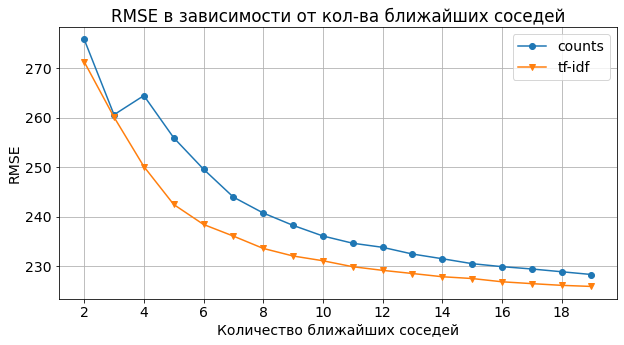

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(10, 5))

p1 = ax.plot(np.arange(2, 20), accuracy_table[0], '-o')
p2 = ax.plot(np.arange(2, 20), accuracy_table[1], '-v')

ax.set_title('RMSE в зависимости от кол-ва ближайших соседей')
ax.set_ylabel('RMSE')
ax.set_xlabel('Количество ближайших соседей')
ax.grid(True)

ax.legend((p1[0], p2[0]), ('counts', 'tf-idf'))
ax.autoscale_view()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
fig.savefig("RMSE_num_neigh.pdf", bbox_inches='tight')

plt.show()

'Tf-Idf' показал лучший результат. В отличии от стратегии 'bag of words' tf idf еще учитывает частоты слов в документах и коллекциях. Так, веса часто встречаемых слов во всех документах 'Tf-Idf' будет занулять, а 'bow' нет, что не совсем логично (про 'bow').

In [ ]:
accuracy_table2 = np.zeros((2, 10))

In [ ]:
for k in range(12, 22):
    knn = KNNRegressor(k, metric='cosine', mode='distance')
    knn.fit(tf_idfs[:X_train.shape[0], :], y_train)
    accuracy_table2[1, k-12] = np.sqrt(mean_squared_error(y_test, knn.predict(tf_idfs[X_train.shape[0]:, :])))
    
    knn = KNNRegressor(k, metric='euclidean', mode='distance')
    knn.fit(tf_idfs[:X_train.shape[0], :], y_train)
    accuracy_table2[0, k-12] = np.sqrt(mean_squared_error(y_test, knn.predict(tf_idfs[X_train.shape[0]:, :])))

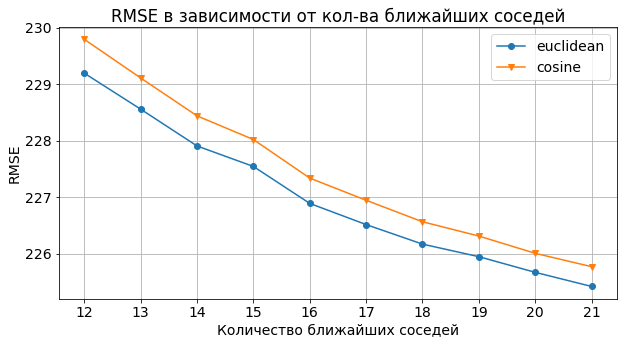

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(10, 5))

p1 = ax.plot(np.arange(12, 22), accuracy_table2[0, :], '-o')
p2 = ax.plot(np.arange(12, 22), accuracy_table2[1, :], '-v')

ax.set_title('RMSE в зависимости от кол-ва ближайших соседей')
ax.set_ylabel('RMSE')
ax.set_xlabel('Количество ближайших соседей')
ax.grid(True)

ax.legend((p1[0], p2[0]), ('euclidean', 'cosine'))
ax.autoscale_view()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
fig.savefig("RMSE_num_neigh2.pdf", bbox_inches='tight')

plt.show()

'Cosine' выиграл, т.к. имеет место 'проклятие размерностей'

<b>3.2 (1 балл)</b> Используя все доступные признаки, решите задачу регрессии. Для категориальных и текстовых признаков выберите лучшие преобразования (из сделанных раннее заданий). Повлияло ли добавление количественного признака на метрику качества?

In [ ]:
import scipy as sc

In [ ]:
nX_train = sc.sparse.hstack((cX_train, tf_idfs[:X_train.shape[0], :]))
nX_test = sc.sparse.hstack((cX_test, tf_idfs[X_train.shape[0]:, :]))

In [ ]:
def flattened_overlap_ec_p(X, Z):
    X_ec = X[:, 3:]
    Z_ec = Z[:, 3:]

    X_cat = X[:, :3].toarray()[0, :]
    Z_cat = Z[:, :3].toarray()[0, :]

    res_eq = sklearn.metrics.pairwise_distances(X_ec, Z_ec, metric='cosine', n_jobs=-1)
    
    indx = (X_cat != Z_cat)
    p_r_ans = np.array(Z_cat, dtype='float32')
    p_r_ans[indx] = 1
    indx = ~indx
        
    funcs = [ap0f, ap1f, ap2f]
    for ci in range(3):
        if indx[ci] != 0:
            p_r_ans[ci] = funcs[ci](p_r_ans[ci])
            
    res_cat = np.sum(p_r_ans)
    
    return res_eq[0, 0] + res_cat
    

Т.к. расстояние по категориальному признаку <= 1  ->  маштабировать не надо (оно понадобилось бы если > 1, т.к. 'cosine' метрика от 0 до 1) 

In [ ]:
knn = KNNRegressor(20, metric=flattened_overlap_ec_p, mode='distance')
knn.fit(nX_train, y_train)
print(np.sqrt(mean_squared_error(y_test, knn.predict(nX_test))))

Поскольку использование расстояния для категориальных признаков 'flattened_overlap', а для остальных 'cosine' слишком долгое, пришлось использовать mean-target кодирование взамен

In [ ]:
nX_train = sc.sparse.hstack((dcX_train, tf_idfs[:X_train.shape[0], :]))
nX_test = sc.sparse.hstack((dcX_test, tf_idfs[X_train.shape[0]:, :]))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

tdcX_train = scaler.fit_transform(dcX_train)
tdcX_test = scaler.transform(dcX_test)

nX_train = sc.sparse.hstack((tdcX_train, tf_idfs[:X_train.shape[0], :]))
nX_test = sc.sparse.hstack((tdcX_test, tf_idfs[X_train.shape[0]:, :]))

In [ ]:
knn = KNNRegressor(20, metric='cosine', mode='distance')
knn.fit(nX_train, y_train)
print(np.sqrt(mean_squared_error(y_test, knn.predict(nX_test))))

211.98432744775988


Катег. + текст. признаки, итог:  RMSE 212

In [ ]:
other_f = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 
           'calculated_host_listings_count', 'availability_365']

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

tdcX_train = scaler.fit_transform(X_train[other_f])
tdcX_test = scaler.transform(X_test[other_f])

nX_train = sc.sparse.hstack((tdcX_train, nX_train))
nX_test = sc.sparse.hstack((tdcX_test, nX_test))

In [ ]:
knn = KNNRegressor(20, metric='cosine', mode='distance')
knn.fit(nX_train, y_train)
print(np.sqrt(mean_squared_error(y_test, knn.predict(nX_test))))

205.9699017091521


Добавление отмаштабированных остальных признаков улучшило скор на ~ 3%

## Часть 4: Выводы


* среди категориальных признаков:
  * *overlap*: самый быстрй
  * *log_overlap*: самый точный
  * *flattened_overlap*: посередине
* при "проклятии размерностей" помогет 'cosine' метрика
* tf-idf лучше counter